In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time
import math
import netCDF4 as nc

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing

RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

#  32.5,  33.5
# -97.5, -96.5

In [2]:
folder = "spatial"
node_id = "10004098"
dir_out = "../figures/" + folder + "/"
dir_data = "../data/"

fn_in = dir_data + "driving_" + node_id + "_landsat_NEXRAD.csv"


In [1]:
df = pd.read_csv(fn_in, index_col = 'UTC')

NameError: name 'pd' is not defined

In [4]:
df.head()

,Illuminance,360nm,361nm,362nm,363nm,364nm,365nm,366nm,367nm,368nm,...,ROI 1km,ROI 2km,ROI 3km,ROI 4km,ROI 5km,ROI 6km,ROI 7km,ROI 8km,ROI 9km,ROI 10km
UTC,,,,,,,,,,,,,,,,,,,,,
2020-01-08 16:43:40,3849.500854,0.042302,0.042491,0.043221,0.044318,0.045591,0.046490,0.047298,0.047995,0.048536,...,183.993026,190.362532,196.732211,203.101717,209.471395,215.840901,222.210464,228.580086,234.949649,241.319271
2020-01-08 16:43:50,2345.220551,0.032529,0.032651,0.033183,0.033997,0.034946,0.035627,0.036239,0.036761,0.037158,...,176.948716,183.193444,189.438345,195.683073,201.927974,208.172702,214.417487,220.662330,226.907116,233.151959
2020-01-08 16:44:00,2385.540894,0.033112,0.033226,0.033758,0.034580,0.035541,0.036231,0.036851,0.037380,0.037782,...,177.429999,183.703189,189.976552,196.249742,202.523106,208.796295,215.069543,221.342848,227.616096,233.889401
2020-01-08 16:44:10,2566.076355,0.033985,0.034098,0.034641,0.035480,0.036464,0.037165,0.037798,0.038343,0.038761,...,182.433789,188.805076,195.176537,201.547824,207.919284,214.290571,220.661916,227.033319,233.404663,239.776066
2020-01-08 16:44:20,2944.573364,0.040020,0.040161,0.040814,0.041823,0.043005,0.043871,0.044654,0.045327,0.045841,...,191.270010,197.798668,204.327500,210.856159,217.384991,223.913650,230.442366,236.971141,243.499857,250.028632


In [18]:
features = ['Zenith',
            'surface reflectance band 1', 'surface reflectance band 2', 'surface reflectance band 3', 'surface reflectance band 4',
            'reflectivity 0km', 'reflectivity 1km',
            'reflectivity 2km', 'reflectivity 3km', 'reflectivity 4km',
            'reflectivity 5km', 'reflectivity 6km', 'reflectivity 7km',
            'reflectivity 8km', 'reflectivity 9km', 'reflectivity 10km',
            'velocity 0km', 'velocity 1km', 'velocity 2km', 'velocity 3km',
            'velocity 4km', 'velocity 5km', 'velocity 6km', 'velocity 7km',
            'velocity 8km', 'velocity 9km', 'velocity 10km', 'spectrum_width 0km',
            'spectrum_width 1km', 'spectrum_width 2km', 'spectrum_width 3km',
            'spectrum_width 4km', 'spectrum_width 5km', 'spectrum_width 6km',
            'spectrum_width 7km', 'spectrum_width 8km', 'spectrum_width 9km',
            'spectrum_width 10km', 'differential_phase 0km',
            'differential_phase 1km', 'differential_phase 2km',
            'differential_phase 3km', 'differential_phase 4km',
            'differential_phase 5km', 'differential_phase 6km',
            'differential_phase 7km', 'differential_phase 8km',
            'differential_phase 9km', 'differential_phase 10km',
            'differential_reflectivity 0km', 'differential_reflectivity 1km',
            'differential_reflectivity 2km', 'differential_reflectivity 3km',
            'differential_reflectivity 4km', 'differential_reflectivity 5km',
            'differential_reflectivity 6km', 'differential_reflectivity 7km',
            'differential_reflectivity 8km', 'differential_reflectivity 9km',
            'differential_reflectivity 10km', 'cross_correlation_ratio 0km',
            'cross_correlation_ratio 1km', 'cross_correlation_ratio 2km',
            'cross_correlation_ratio 3km', 'cross_correlation_ratio 4km',
            'cross_correlation_ratio 5km', 'cross_correlation_ratio 6km',
            'cross_correlation_ratio 7km', 'cross_correlation_ratio 8km',
            'cross_correlation_ratio 9km', 'cross_correlation_ratio 10km',
            'ROI 0km', 'ROI 1km', 'ROI 2km', 'ROI 3km', 'ROI 4km', 'ROI 5km',
            'ROI 6km', 'ROI 7km', 'ROI 8km', 'ROI 9km', 'ROI 10km']
wavelengths = np.array(range(360,780+1)).astype(str)
for i in range(len(wavelengths)):
    wavelengths[i] = wavelengths[i] + 'nm'
wavelengths = list(wavelengths)

target = 'whole'
targets = wavelengths

In [5]:
X = df[features]
X.rename(columns={'surface reflectance band 1': 'surface reflectance (435-451 nm)',\
                  'surface reflectance band 2': 'surface reflectance (452-512 nm)',\
                  'surface reflectance band 3': 'surface reflectance (533-590 nm)',\
                  'surface reflectance band 4': 'surface reflectance (636-673 nm)'}, inplace = True)
Y = df[targets]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0) 

features = X.columns
targets = Y.columns


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
max_depth = 39 #CV_rfr.best_params_['max_depth'], # 30
n_estimators = 64 #CV_rfr.best_params_['n_estimators'])#100
min_samples_split = 8
min_samples_leaf = 1
max_samples = None
max_features = 1.0

start_time = time.time()

regr = RandomForestRegressor(random_state = RANDOM_STATE,
                             max_depth = max_depth,
                             n_estimators = n_estimators,
                             min_samples_split = min_samples_split,
                             min_samples_leaf = min_samples_leaf,
                             max_samples = max_samples,
                             max_features = max_features,
                             n_jobs = n_jobs)
regr.fit(X_train, Y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 494.7514922618866 seconds ---


In [7]:
structure =  '_dep' + str(max_depth) \
            +'_ne' + str(n_estimators) \
            +'_splt' + str(min_samples_split) \
            +'_lf' + str(min_samples_leaf)\
            +'_sr' + str(max_samples)\
            +'_fr' + str(max_features)
fn_model = '../models/spatial_RF_' + target + structure +'.sav'
pickle.dump(regr, open(fn_model, 'wb'))


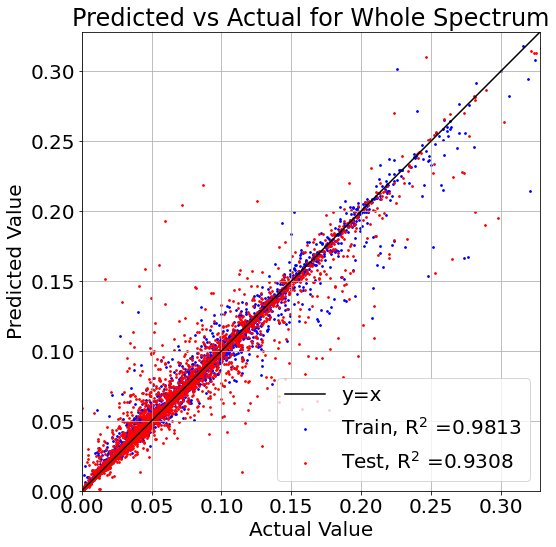

In [266]:
from sklearn.metrics import r2_score
Y_train_pred = regr.predict(X_train)
train_score = r2_score(Y_train, Y_train_pred)

Y_test_pred = regr.predict(X_test)
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 5000, replace = False)
plt.scatter(Y_train_flatten[id_train],Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
id_test = np.random.choice(len(Y_test_flatten), 5000, replace = False)
plt.scatter(Y_test_flatten[id_test],Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim(Y_min, Y_max)
plt.ylim(Y_min, Y_max)

ax.set_title('Predicted vs Actual for Whole Spectrum')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target):
    os.mkdir(dir_out + target)
plt.savefig(dir_out + target +'/spatial_RF_performance_'+target+structure+'.png')


In [9]:
train_scores = []
test_scores = []
for i in range(len(wavelengths)):
    train_scores.append( r2_score(Y_train.iloc[:,i], Y_train_pred[:,i]) )
    test_scores.append( r2_score(Y_test.iloc[:,i], Y_test_pred[:,i]) )


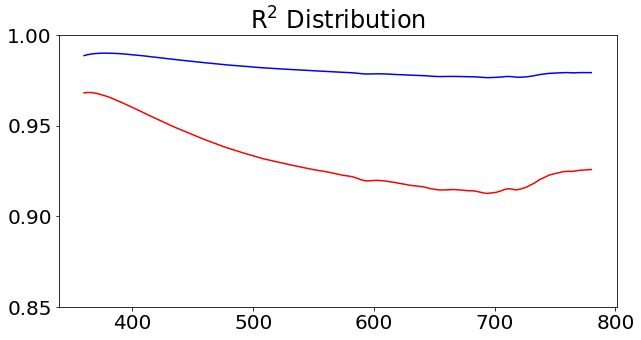

In [10]:
plt.rcParams["figure.figsize"] = (10, 5) # (w, h)
plt.plot(np.array(range(360,780+1)),train_scores, 'b', label = 'Train')
plt.plot(np.array(range(360,780+1)),test_scores, 'r', label = 'Test')
plt.ylim(0.85,1)
plt.title("R$^2$ Distribution")
plt.savefig(dir_out + 'whole' + '/spatial_RF_R2+'+target+structure+'.png')

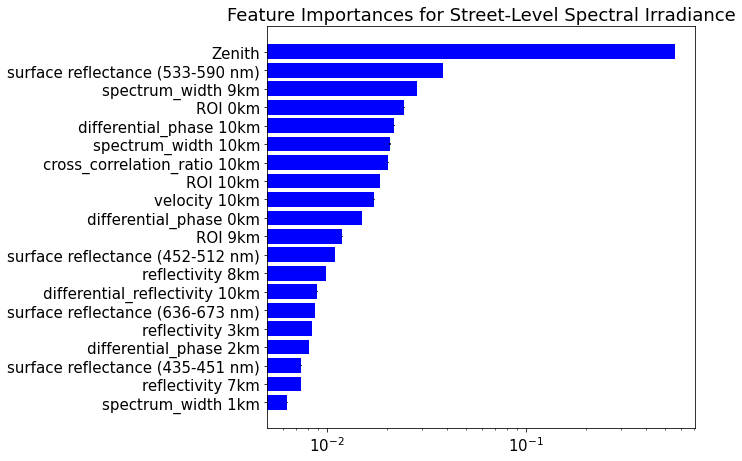

In [268]:
# rank feature inportance
num_features = 20
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

var_sorted = features[indices]
var_imp_sorted = importances[indices]

plt.rcParams["figure.figsize"] = (10, num_features/3) # (w, h)
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features], var_imp_sorted[:num_features],
        yerr=std[indices][:num_features], ecolor='black',
        color = 'blue', align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Feature Importances for Street-Level Spectral Irradiance')
plt.xscale("log")
plt.tight_layout()
plt.savefig(dir_out + target + '/spatial_RF_RFImportances_'+target+structure+'.png')

In [29]:
# Create object that can calculate shap values
start_time = time.time()

num_shap = 200
X_sample = shap.sample(X_train, num_shap)
explainer = shap.TreeExplainer(regr)
# Calculate shap_values
shap_values = explainer.shap_values(X_sample)

print("--- %s seconds ---" % (time.time() - start_time))

--- 148.88766527175903 seconds ---


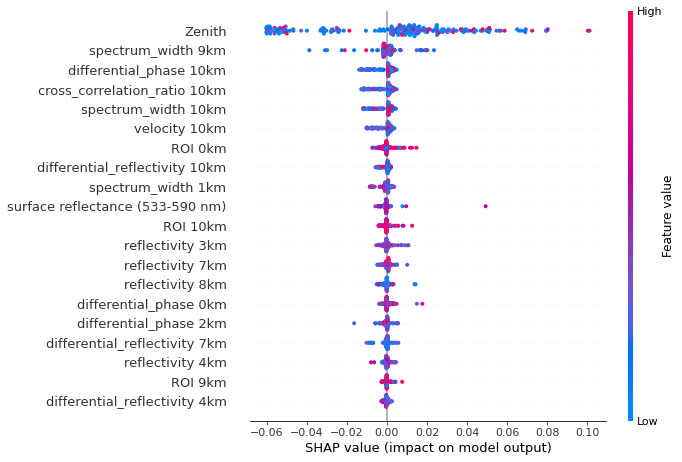

In [41]:
# plot
max_display = 20
shap.summary_plot(np.mean(shap_values, axis = 0), X_train[:num_shap],
                  plot_size=(10,max_display/3),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + target + '/spatial_RF_shap_'+ target+structure +'.png')

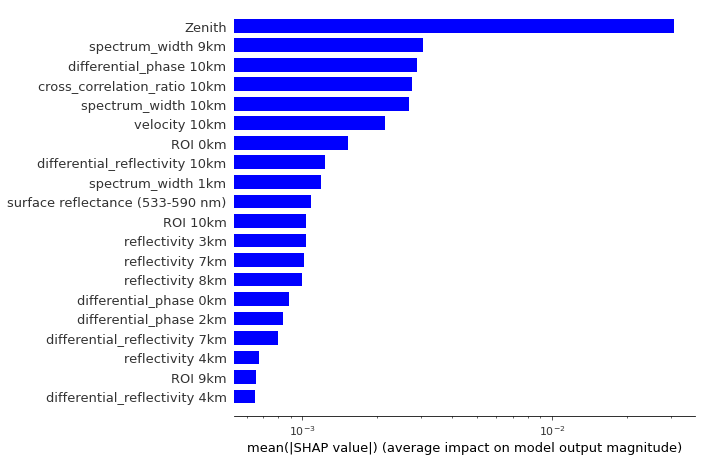

In [44]:
shap.summary_plot(np.mean(shap_values, axis = 0), X_sample,
                  plot_size=(10,max_display/3),#'auto'
                  color = 'blue',
                  max_display = max_display,
                  show=False,
                  plot_type = 'bar'
                 )
plt.xscale("log")
ax.set_title('Feature Importances for Street-Level Spectral Irradiance')
plt.tight_layout()
plt.savefig(dir_out + target + '/spatial_RF_Importances_'+target+structure+'.png')

## Compare Full Spectrum with Prediction


In [97]:
from wavelength_to_rgb import wavelength_to_rgb
clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)


In [269]:
jetlag = 6

year = 2020
month = 2
day = 10
hour = 13+jetlag
minute = 0
second = 0
date_string = '%04d-%02d-%02d %02d:%02d:%02d' % (year, month, day, hour, minute, second)
iwant = (X.index == date_string)


wavelengths = np.array(range(360,780+1))

x1 = X[iwant].index.values
y1 = Y[iwant].values
y1_pred = regr.predict(X[iwant])

date_string

'2020-02-10 19:00:00'

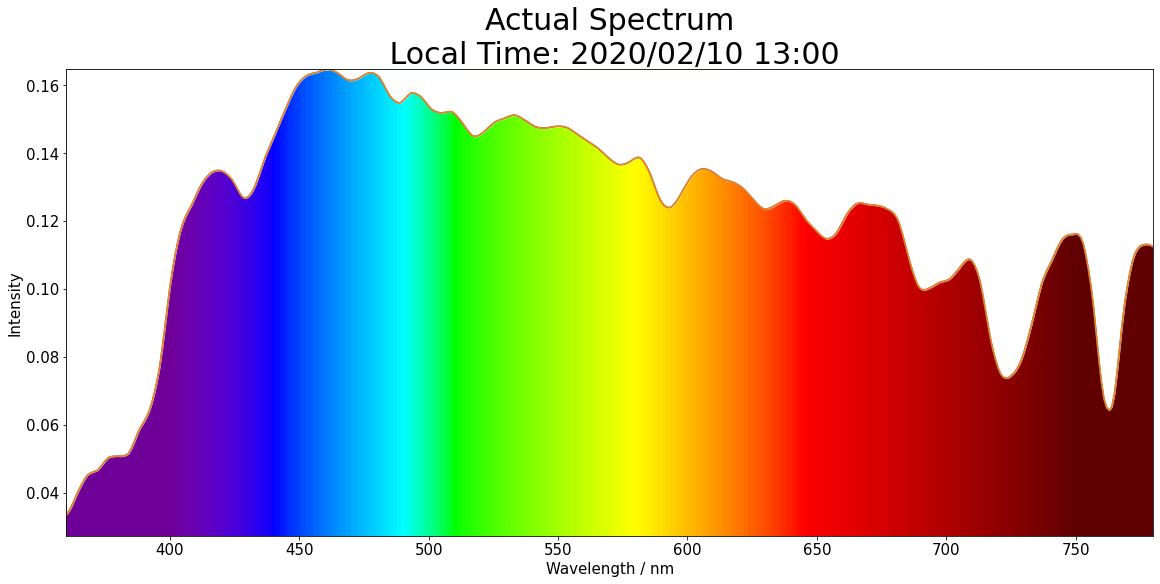

In [270]:
y_plot_min = np.min([np.min(y1), np.min(y1_pred)])
y_plot_max = np.max([np.max(y1), np.max(y1_pred)])


fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})

spectrum = y1.flatten()
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, y_plot_max, 100)

XX,YY = np.meshgrid(wavelengths, y2)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), y_plot_min, y_plot_max)

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, y_plot_max, color='w')
ax.set_title('Actual Spectrum\n Local Time: %02d/%02d/%02d %02d:%02d' % (year, month, day, hour-jetlag, minute))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Intensity')

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d_%02d.png' % (year, month, day, hour-jetlag, minute))
#plt.close()

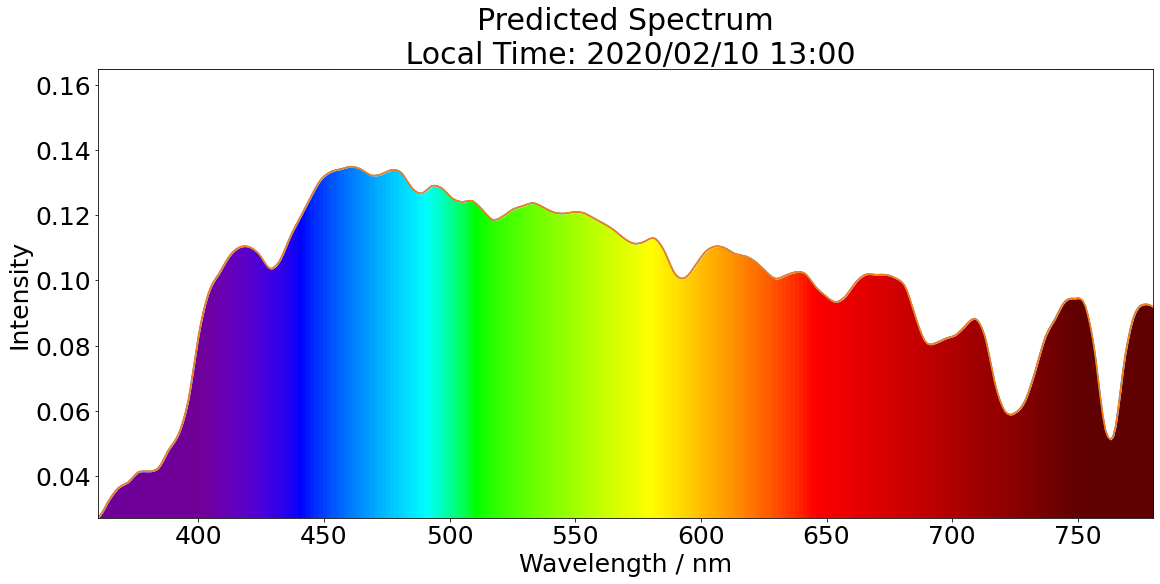

In [271]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
spectrum = y1_pred.flatten()
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y2)
XX[XX<400] = 400
# extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))
# y_upper = np.max(spectrum)*1.1

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, y_plot_max, color='w')
ax.set_title('Predicted Spectrum\n Local Time: %02d/%02d/%02d %02d:%02d' % (year, month, day, hour-jetlag, minute))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Intensity')

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d_%02d_pred.png' % (year, month, day, hour-jetlag, minute))
#plt.close()